In [13]:
import wandb
import torch
import torch.nn as nn
import pandas as pd
import seaborn as sns
import lovely_tensors
from tqdm.notebook import tqdm
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torch.nn.functional import sigmoid
import math
import matplotlib.pyplot as plt
import seaborn as sns

lovely_tensors.monkey_patch()

In [14]:
class LearnablePositionalEncoding(nn.Module):
    def __init__(self, out_dim, dim=50, max_len=1000):
        super().__init__()

        self.pos_enc = nn.Parameter(torch.zeros(max_len, dim))
        self._init_pos_enc(dim, max_len)

        self.linear1 = nn.Linear(dim, out_dim)
        self.linear2 = nn.Linear(out_dim, out_dim)
        self.relu = nn.ReLU()

    def forward(self, t):
        x = self.pos_enc[t]
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        return x

    def _init_pos_enc(self, d_model, max_len):
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        self.pos_enc.data[:, 0::2] = torch.sin(position * div_term)
        self.pos_enc.data[:, 1::2] = torch.cos(position * div_term)

In [15]:
class BackwardsDiffusionModel(nn.Module):
    def __init__(self, in_dim=2, dim=128, num_steps=1000):
        super().__init__()

        self.pos_enc = LearnablePositionalEncoding(dim)

        self.linear1 = nn.Linear(in_dim, dim)
        self.linear2 = nn.Linear(dim, dim)
        self.linear3 = nn.Linear(dim, dim)
        self.linear4 = nn.Linear(dim, in_dim)

        self.relu = nn.ReLU()

    def forward(self, x: torch.Tensor, t: int):
        pos_enc = self.pos_enc(t)

        x = self.relu(self.linear1(x) + pos_enc)
        x = self.relu(self.linear2(x) + pos_enc)
        x = self.relu(self.linear3(x) + pos_enc)
        x = self.linear4(x)

        return x

In [16]:
x = torch.randn(128, 16).cuda()
t = torch.ones(128, dtype=torch.long).cuda()

model = BackwardsDiffusionModel(in_dim=16).cuda()
model(x, t)

tensor[128, 16] n=2048 (8Kb) x∈[-0.249, 0.264] μ=0.043 σ=0.104 grad AddmmBackward0 cuda:0

---

In [17]:
class DDPM:
    def __init__(
        self, backward_model, num_steps=1000, beta_start=0.0001, beta_end=0.02, use_sigmoid=True, device="cuda:0"
    ):
        self.device = torch.device(device)
        self.num_steps = num_steps
        self.backward_model = backward_model.to(device)

        if use_sigmoid:
            self.alpha_cumprod = sigmoid(torch.linspace(5, -5, num_steps))
            alphas = torch.zeros_like(self.alpha_cumprod)
            alphas[0] = 1 - beta_start
            alphas[1:] = self.alpha_cumprod[1:] / self.alpha_cumprod[:-1]
            self.alphas = alphas
            self.betas = 1 - alphas
        else:
            self.betas = torch.linspace(beta_start, beta_end, num_steps)
            self.alphas = 1 - self.betas
            self.alpha_cumprod = torch.cumprod(self.alphas, dim=0)

        self.alpha_cumprod = self.alpha_cumprod.to(device)
        self.alphas = self.alphas.to(device)
        self.betas = self.betas.to(device)

    @torch.no_grad()
    def forward_diffusion(self, x, t, noise=None):
        if type(t) == int:
            t = torch.tensor([t])
        noise = torch.randn_like(x) if noise is None else noise

        a = torch.sqrt(self.alpha_cumprod[t]).unsqueeze(1)
        b = torch.sqrt(1 - self.alpha_cumprod[t]).unsqueeze(1)

        return a * x + b * noise

    @torch.no_grad()
    def generate(self, n):
        x = torch.randn((n, 2), device=self.device)

        for t in range(self.num_steps - 1, -1, -1):
            z = torch.randn_like(x) if t >= 1 else torch.zeros_like(x)
            t_tensor = torch.full((n,), t, device=self.device, dtype=torch.long)
            noise_pred = self.backward_model(x, t_tensor)

            a_t = self.alphas[t]
            a_bar_t = self.alpha_cumprod[t]

            x = (1 / a_t.sqrt()) * (x - noise_pred * (1 - a_t) / (1 - a_bar_t).sqrt()) + (1 - a_t).sqrt() * z

        return x

In [18]:
def plot(X, limit=2000, show=True):
    X = X.cpu()
    n = X.shape[0]

    if limit is not None and n > limit:
        indices = torch.randperm(n)[:limit]
        X = X[indices]

    fig, ax = plt.subplots()
    sns.scatterplot(x=X[:, 0], y=X[:, 1], ax=ax, s=20)
    ax.set_xlim(-1.2, 1.2)
    ax.set_ylim(-1.2, 1.2)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_title("")
    if not show:
        plt.close(fig)
        return fig
    else:
        plt.show()

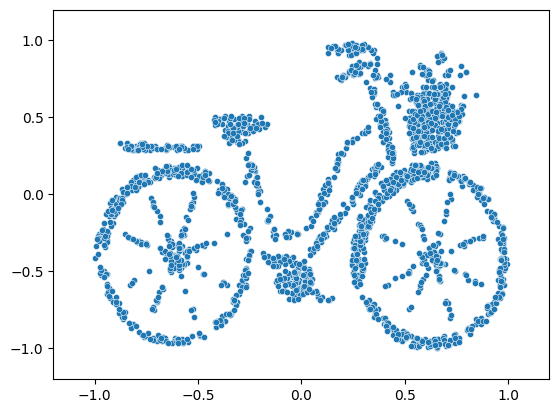

tensor[50468, 2] n=100936 (0.4Mb) x∈[-1.000, 1.000] μ=0.026 σ=0.531 cuda:0

In [19]:
df = pd.read_csv("bicycle.txt", header=None, delimiter=" ")
df = df.sample(frac=1)
X = torch.tensor(df.values).float().cuda()
plot(X)
X

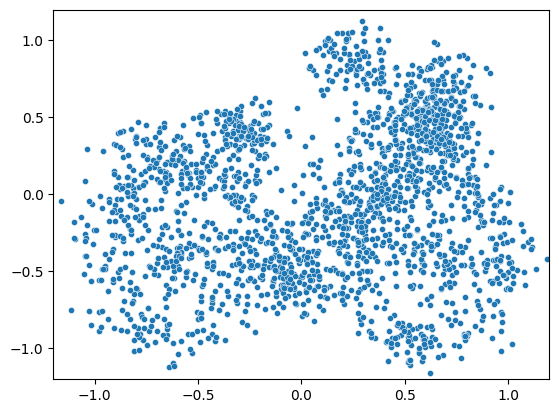

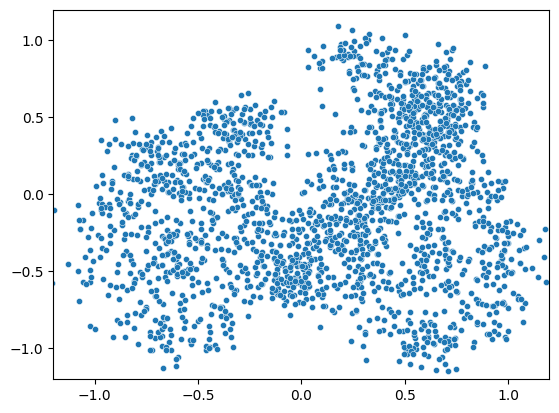

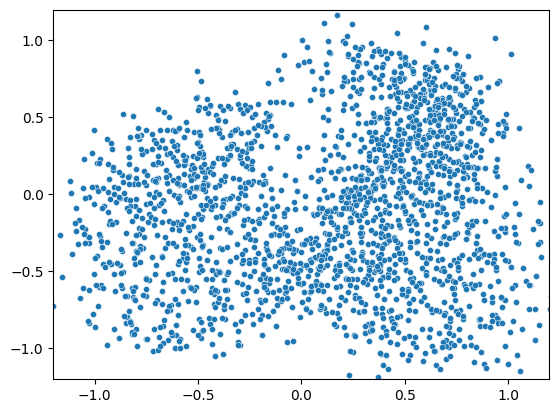

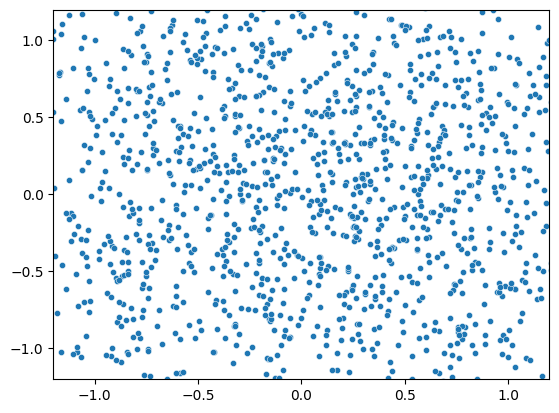

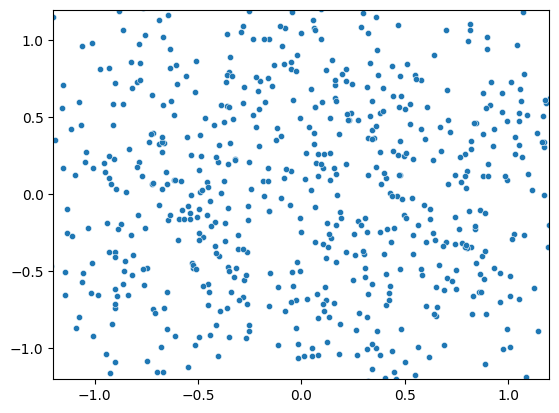

In [20]:
ddpm = DDPM(BackwardsDiffusionModel(in_dim=2))

for t in [1, 10, 100, 999]:
    diff_X = ddpm.forward_diffusion(X, t)
    plot(diff_X)

plot(torch.randn(1000, 2))

<Axes: >

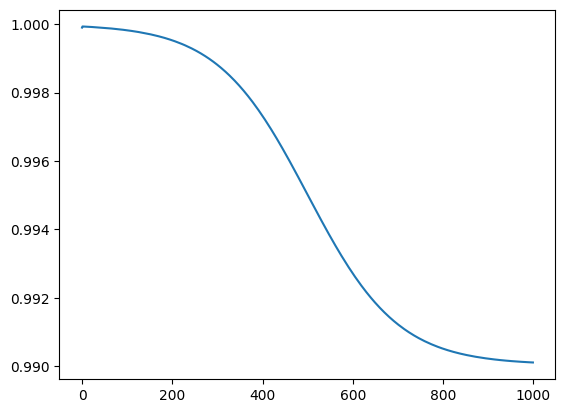

In [21]:
sns.lineplot(ddpm.alphas.cpu())

<Axes: >

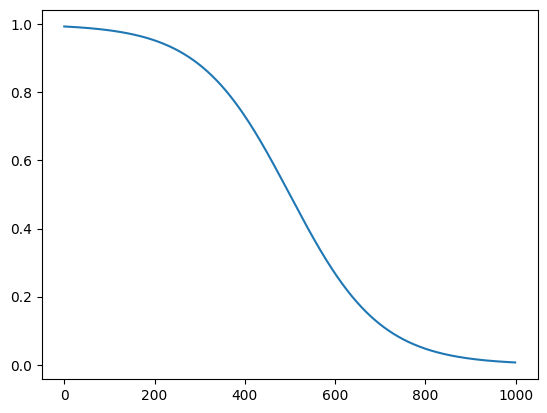

In [22]:
sns.lineplot(ddpm.alpha_cumprod.cpu())

In [9]:
df = pd.read_csv("bicycle.txt", header=None, delimiter=" ")
df = df.sample(frac=1)
X = torch.tensor(df.values).float().cuda()

train_loader = DataLoader(X, batch_size=128, shuffle=True)
test_loader = DataLoader(X, batch_size=128, shuffle=True)

In [ ]:
wandb.init(project="MRO-DDPM")

backward_model = BackwardsDiffusionModel().cuda()
ddpm = DDPM(backward_model, use_sigmoid=False)
optim = Adam(backward_model.parameters(), lr=0.0001)
mse = nn.MSELoss()
total_epochs = 1000

pbar = tqdm(total=total_epochs)
for epoch in range(total_epochs):
    running_loss = 0
    for x_0 in train_loader:
        x_0 = x_0.cuda()
        t = torch.randint(0, 1000, (x_0.size(0),)).cuda()
        noise = torch.randn_like(x_0).cuda()
        x_t = ddpm.forward_diffusion(x_0, t, noise)
        noise_est = ddpm.backward_model(x_t, t)
        loss = mse(noise_est, noise)

        optim.zero_grad()
        loss.backward()
        optim.step()

        running_loss += loss

    running_loss = running_loss.item() / len(train_loader)
    pbar.update(1)
    pbar.set_description(f"Loss: {running_loss:.4f}")

    if epoch == int(0.8 * total_epochs):
        for param_group in optim.param_groups:
            param_group["lr"] /= 10
        print("LR reduced")

    to_log = {"loss": running_loss, "lr": optim.param_groups[0]["lr"]}

    if epoch % 10 == 0:
        gen_X = ddpm.generate(1000)
        to_log.update({"generated": wandb.Image(plot(gen_X, show=False))})
        plot(gen_X)

    wandb.log(to_log)